# Задание

Познакомиться с принципом работы Kafka и применить его на практике, выполнив следующие пункты:
* Имитировать сбор данных.
* Обработка данных, препроцессинг.
* Анализ данных с помощью ML/DL.
* Визуализация — создать Dashboard с использованием Streamlit.

# Настройки/Импорты

In [ ]:
# !pip install confluent-kafka
# !pip install streamlit

Версии важных модулей:
* scikit-learn==1.2.2
* pandas==2.1.1
* numpy==1.26.2

In [1]:
import pandas as pd # для удобной работы с датасетом
import numpy as np # для работы с массивами
import re # для регулярных выражений
from sklearn import preprocessing # для конвертации строковых данных в численные

from sklearn.model_selection import train_test_split # для разбиения на обучающую и тестовую выборку
from sklearn.model_selection import GridSearchCV # для перебора параметров
from sklearn.model_selection import ShuffleSplit # для кросс-валидации
from sklearn.utils import resample # для upsample и downsample данных (выравнивание классов)

from sklearn.neighbors import KNeighborsClassifier # KNN классификатор

from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay # для оценки качества предсказаний
import time # для отслеживания времени выполнения
import matplotlib.pyplot as plt # для построения графиков

import pickle # для сохранения и загрузки объектов

import warnings # для обработки предупреждений
warnings.simplefilter(action='ignore', category=FutureWarning) # игнорируем FutureWarning

In [34]:
DATA_DIR = "./data/" # путь до папки с данными
MODELS_DIR = "./models/" # путь до папки с моделями

RANDOM_STATE = 42 # число для задания случайности

N_JOBS = -1 # количество потоков для параллельного выполнения некоторых участков кода (связанных с перебором параметров)
VERBOSE = 0 # на сколько подробным должен быть вывод при обучении

CV_SPLITS = 2 # число разбиений для кросс-валидации
TEST_SIZE = 0.2 # размер тестовой выборки

MAX_SAMPLES = 100000 # максимальное число сэмплов в классе

# Предобработка датасета

В качестве рассматриваемого датасета был выбран [Credit Card Fraud Prediction](https://www.kaggle.com/datasets/kelvinkelue/credit-card-fraud-prediction/), содержащий различные данные о транзакциях (в нём нет пропущенных значений). 

Цель — определить, является ли проведённая операция мошеннической или нет.

**Столбцы:**
1) Trans_date_trans_time: timestamp транзакции (дата и время).
2) Cc_num: уникальный идентификационный номер покупателя.
3) Merchant: продавец, участвующий в сделке.
4) Category: тип транзакции (например: personal или childcare).
5) Amt: сумма транзакции.
6) First: имя владельца карты.
7) Last фамилия владельца карты.
8) Gender: пол владельца карты.
9) Street: улица проживания владельца карты.
10) City: город проживания владельца карты.
11) State: страна проживания владельца карты.
12) Zip: zip code владельца карты.
13) Lat: широта местоположения владельца карты.
14) Long: долгота местоположения владельца карты.
15) City_pop: население города владельца карты.
16) Job: должность владельца карты.
17) Dob: дата рождения владельца карты.
18) Trans_num: уникальный идентификатор транзакции.
19) Unix_time: timestamp транзакции (Unix формат).
20) Merch_lat: местоположение продавца (широта).
21) Merch_long: местоположение продавца (долгота).
22) Is_fraud: индикатор мошеннической транзакции (0 — законная, 1 — мошенническая), является target-переменной задачи классификации.

In [3]:
dataset = pd.read_csv(f"{DATA_DIR}fraud test.csv",  sep=',', encoding='utf8', index_col=0) # считывание данных (колонки разделены с помощью sep, данные хранятся в кодировке encoding, индексы указаны в колонке index_col (None, если в данных её изначально нет))
dataset

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,31/12/2020 23:59,3.056060e+13,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,...,40.4931,-91.8912,519,Town planner,13/02/1966,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
555715,31/12/2020 23:59,3.556610e+15,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,...,29.0393,-95.4401,28739,Futures trader,27/12/1999,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
555716,31/12/2020 23:59,6.011720e+15,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,...,46.1966,-118.9017,3684,Musician,29/11/1981,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
555717,31/12/2020 23:59,4.079770e+12,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,...,44.6255,-116.4493,129,Cartographer,15/12/1965,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  float64
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-null  i

In [5]:
dataset["is_fraud"].value_counts() # баланс классов сильно несбалансированный

is_fraud
0    553574
1      2145
Name: count, dtype: int64

**Удалим из датасета те столбцы, что не должны нести информацию о мошенничестве.**

Среди данных столбцов (они субъективны): first, last, street, city, state (вместо них есть точное положение lat, long), zip, trans_num, unix_time.

In [6]:
dataset.drop(columns=["first", "last", "street", "city", "state", "zip", "trans_num", "unix_time"], inplace=True) # удаляем лишние столбцы
dataset

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud
0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,M,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,33.986391,-81.200714,0
1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,F,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,39.450498,-109.960431,0
2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,40.495810,-74.196111,0
3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,M,28.5697,-80.8191,54767,Set designer,25/07/1987,28.812398,-80.883061,0
4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,M,44.2529,-85.0170,1126,Furniture designer,06/07/1955,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,31/12/2020 23:59,3.056060e+13,fraud_Reilly and Sons,health_fitness,43.77,M,40.4931,-91.8912,519,Town planner,13/02/1966,39.946837,-91.333331,0
555715,31/12/2020 23:59,3.556610e+15,fraud_Hoppe-Parisian,kids_pets,111.84,M,29.0393,-95.4401,28739,Futures trader,27/12/1999,29.661049,-96.186633,0
555716,31/12/2020 23:59,6.011720e+15,fraud_Rau-Robel,kids_pets,86.88,F,46.1966,-118.9017,3684,Musician,29/11/1981,46.658340,-119.715054,0
555717,31/12/2020 23:59,4.079770e+12,fraud_Breitenberg LLC,travel,7.99,M,44.6255,-116.4493,129,Cartographer,15/12/1965,44.470525,-117.080888,0


**Изменим тип некоторых колонок (фич).**

Используемая дальше модель умеет работать только с числовым типом данных (float и int).

In [7]:
label_encoders = {} # словарь под LabelEncoder для столбцов

In [8]:
dataset["trans_date_trans_time"] = pd.to_datetime(dataset["trans_date_trans_time"], format="%d/%m/%Y %H:%M") # приводим колонку к типу времени
dataset["trans_date_trans_time"] = pd.to_numeric(dataset["trans_date_trans_time"]) # конвертируем дату в число (потому что модели не умеют работать с типом date)

dataset["dob"] = pd.to_datetime(dataset["dob"], format="%d/%m/%Y") # приводим колонку к типу времени
dataset["dob"] = pd.to_numeric(dataset["dob"]) # конвертируем дату в число (потому что модели не умеют работать с типом date)

dataset["merchant"] = dataset["merchant"].apply(lambda text: re.sub('fraud_', '', text)) # удаляем приписки в столбце merchant

for column in ["merchant", "category", "gender", "job"]: # идём по столбцам, что нужно сконвертировать из строк в числа
    encoder = preprocessing.LabelEncoder() # создаём encoder
    dataset[column] = encoder.fit_transform(dataset[column]) # конвертируем строковые столбцы в числовые
    label_encoders[column] = encoder # запоминаем encoder

In [53]:
with open(f"{MODELS_DIR}LabelEncoders.pkl", 'wb') as f: # открытие файла для бинарной ('b') записи ('w')
    pickle.dump(label_encoders, f) # сохраняем энкодеры

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 0 to 555718
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  int64  
 1   cc_num                 555719 non-null  float64
 2   merchant               555719 non-null  int32  
 3   category               555719 non-null  int32  
 4   amt                    555719 non-null  float64
 5   gender                 555719 non-null  int32  
 6   lat                    555719 non-null  float64
 7   long                   555719 non-null  float64
 8   city_pop               555719 non-null  int64  
 9   job                    555719 non-null  int32  
 10  dob                    555719 non-null  int64  
 11  merch_lat              555719 non-null  float64
 12  merch_long             555719 non-null  float64
 13  is_fraud               555719 non-null  int64  
dtypes: float64(6), int32(4), int64(4)
memory 

# Подготовка к обучению

### Используемые объекты

In [10]:
data = {} # словарь с входными данными для модели
# {
#  "X_train": [...],
#  "X_test": [...],
#  "y_train": [...],
#  "y_test": [...],
# }

In [11]:
custom_cv = ShuffleSplit(n_splits=CV_SPLITS, test_size=TEST_SIZE, random_state=RANDOM_STATE) # кастомный кросс-валидатор (n_splits — число разбиений для кросс-валидации, test_size — размер тестовой выборки)

### Разбиение на обучающую и тестовую выборки

In [12]:
data_y = dataset["is_fraud"].to_numpy() # берём таргеты
data_X = dataset.drop(columns=["is_fraud"]).to_numpy() # берём данные (без столбца таргета)

data["X_train"], data["X_test"], data["y_train"], data["y_test"] = train_test_split(data_X, data_y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data_y, shuffle=True)
# разбиваем датасет (data_X — данные, data_y — таргеты) на обучающую и тестовую выборки в соотношении TEST_SIZE, при этом пропорция таргетов должна быть одинаковой (stratify=data_y) в обоих выборках и данные должны быть перемешаны (shuffle=True)

In [13]:
data["X_train"]

array([[ 1.59948222e+18,  6.01138000e+15,  6.44000000e+02, ...,
        -8.72985600e+17,  4.37277500e+01, -8.50463760e+01],
       [ 1.60569930e+18,  3.70877000e+14,  8.70000000e+01, ...,
         4.47379200e+17,  3.68515230e+01, -8.02023030e+01],
       [ 1.60137942e+18,  3.56637000e+15,  1.03000000e+02, ...,
        -1.74441600e+17,  3.47655820e+01, -1.06874102e+02],
       ...,
       [ 1.60911468e+18,  4.80755000e+12,  2.56000000e+02, ...,
        -5.02502400e+17,  4.03142210e+01, -8.36085630e+01],
       [ 1.60451772e+18,  4.18653000e+12,  4.10000000e+01, ...,
        -9.91872000e+16,  3.38605990e+01, -8.20221240e+01],
       [ 1.60754184e+18,  4.45083000e+15,  6.80000000e+01, ...,
         6.47136000e+16,  3.39565670e+01, -9.51262600e+01]])

In [14]:
data["y_train"]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Вспомогательные функции

In [15]:
def model_train(model, params, X_train, y_train, cv, n_jobs=N_JOBS, verbose=VERBOSE, scoring="f1_macro") -> GridSearchCV:
    """
    Универсальная функция для обучения классификаторов.\n
    Parameters:
        * model: классификатор
        * params: параметры для перебора в GreedSearch
        * X_train: данные для обучения
        * y_train: таргеты для обучения
        * cv: метод для кросс-валидации
        * n_jobs: количество потоков для распараллеливания
        * verbose: на сколько подробным должен быть вывод при обучении
        * scoring: метрика для выбора лучшей модели\n
    Returns:
        * GridSearchCV: объект, содержащий
    """
    greed_search = GridSearchCV(model, params, cv=cv , scoring=scoring, n_jobs=n_jobs, verbose=verbose) # передаём параметры в GridSearchCV

    greed_search.fit(X_train, y_train) # обучаем модель

    return greed_search # возвращаем обученный классификатор

In [16]:
def model_save(model, file_name):
    """
    Функция для сохранения модели.\n
    Parameters:
        * model: классификатор, что нужно сохранить
        * file_name: путь, куда сохранять\n
    Returns:
        * None
    """
    with open(file_name, 'wb') as f: # открытие файла для бинарной ('b') записи ('w')
        pickle.dump(model, f) # сохраняем модель

In [17]:
def model_load(file_name):
    """
    Функция для загрузки модели.\n
    Parameters:
        * file_name: путь, по которому лежит сохранённая модель\n
    Returns:
        * возвращает загруженную модель
    """
    with open(file_name, 'rb') as f: # открытие бинарного ('b') файла для чтения ('r')
        return pickle.load(f) # загружаем модель

In [26]:
def investigation(model, params, data, model_name, cv, average="macro") -> dict:
    """
    Функция для исследования модели на определённых данных и нахождения лучших гиперпараметров.\n
    Parameters:
        * model: общая модель, с которой будет взаимодействие
        * params: параметры для перебора при обучении
        * data: данные в формате словаря вида {"X_train": [...], "X_test": [...], "y_train": [...], "y_test": [...]}
        * model_name: название модели
        * cv: параметры кросс-валидации
        * average: тип усреднения для F1 score\n
    Returns:
        * dict: словарь вида {"вариант_обработки": f1 macro score, ...}
    """
    start_time = time.time() # замеряем время, что было при начале обучения
    model_gs = model_train(model, params, data["X_train"], data["y_train"], cv) # вызываем функцию обучения
    train_time = time.time() - start_time # получаем время, затраченное на обучение в секундах

    best_model = model_gs.best_estimator_ # берём лучшую модель
    model_save(best_model, f"{MODELS_DIR}{model_name}.pkl") # сохраняем лучшую модель (с указанием варианта очистки текста)

    print(f"Результаты {model_name}:")
    print(f"   Время, затраченное на обучение: {train_time:.5f}")
    y_pred = best_model.predict(data["X_test"]) # делаем предсказание на тестовой выборке с помощью обученной модели
    results = f1_score(data["y_test"], y_pred, average=average, zero_division=0) # считаем и сохраняем посчитанный f1 score (average: "macro" — по всем класса, без учёта дисбаланса, "weighted": с учётом дисбаланса) (zero_division=0 — деление на ноль заменять нулём)
    print(classification_report(data["y_test"], y_pred, zero_division=0)) # выводим основные метрики, такие как precision, recall, f1-score, accuracy (zero_division=0 — деление на ноль заменять нулём)

    fig, ax = plt.subplots(figsize=(6,6)) # создание "фигуры"
    ConfusionMatrixDisplay(confusion_matrix(data["y_test"], y_pred), display_labels=best_model.classes_).plot(ax=ax) # строим confusion matrix (стоит обратить внимание на display_labels, они могут не совпасть...)
    # fig.autofmt_xdate(rotation=45, ha='right') # поворот подписей на оси OX
    plt.show() # вывод графика
    return results

# Обучение модели

В качестве классификатора был взят **KNN**, так как он быстро обучается.

In [24]:
params = [{
    'n_neighbors': list(range(1, 10)), # кол-во соседей
    'weights': ['uniform', 'distance'], # вдияние расстояния до соседа на его вклад ("uniform" — нет влияния, "distance" — чем ближе, тем больше вклад)
    'metric': ["minkowski"], # метрика для подсчёта расстояния между объектами
    'p': [2], # степень в метрике Минковского расстояния (2 ~ расстояние евклидово)
    'algorithm': ['auto'], # алгоритм для подсчёта ближайших соседей
    }]

model_name = "KNN" # название модели
model = KNeighborsClassifier() # модель

Результаты KNN:
   Время, затраченное на обучение: 95.47122
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       0.91      0.97      0.93       429

    accuracy                           1.00    111144
   macro avg       0.95      0.98      0.97    111144
weighted avg       1.00      1.00      1.00    111144



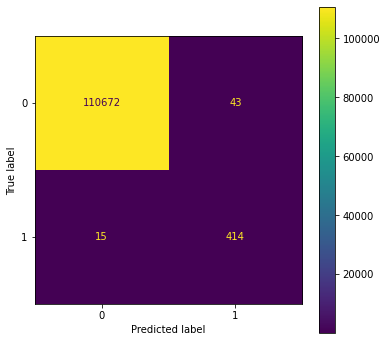

In [27]:
result = investigation(model, params, data, model_name, custom_cv, average="weighted") # обучаем модель, перебираем параметры, сохраняем, оцениванием и запоминаем результатa

In [32]:
print(f"Weighted F1 score: {result}") # F1 score с учётом дисбаланса классов

Weighted F1 score: 0.96713763956488


In [30]:
model = model_load(f"{MODELS_DIR}{model_name}.pkl") # загружаем модель, получившую наивысший f1 score
model.get_params() # параметры модели

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

# Датасет для Kafka

**Сократим количество данных в датасете, удалив большинство записей без мошеннических транзакций.**

In [54]:
dataset = pd.read_csv(f"{DATA_DIR}fraud test.csv",  sep=',', encoding='utf8', index_col=0) # считывание данных (колонки разделены с помощью sep, данные хранятся в кодировке encoding, индексы указаны в колонке index_col (None, если в данных её изначально нет))
dataset.drop(columns=["first", "last", "street", "city", "state", "zip", "trans_num", "unix_time"], inplace=True) # удаляем лишние столбцы
dataset

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud
0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,M,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,33.986391,-81.200714,0
1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,F,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,39.450498,-109.960431,0
2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,40.495810,-74.196111,0
3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,M,28.5697,-80.8191,54767,Set designer,25/07/1987,28.812398,-80.883061,0
4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,M,44.2529,-85.0170,1126,Furniture designer,06/07/1955,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,31/12/2020 23:59,3.056060e+13,fraud_Reilly and Sons,health_fitness,43.77,M,40.4931,-91.8912,519,Town planner,13/02/1966,39.946837,-91.333331,0
555715,31/12/2020 23:59,3.556610e+15,fraud_Hoppe-Parisian,kids_pets,111.84,M,29.0393,-95.4401,28739,Futures trader,27/12/1999,29.661049,-96.186633,0
555716,31/12/2020 23:59,6.011720e+15,fraud_Rau-Robel,kids_pets,86.88,F,46.1966,-118.9017,3684,Musician,29/11/1981,46.658340,-119.715054,0
555717,31/12/2020 23:59,4.079770e+12,fraud_Breitenberg LLC,travel,7.99,M,44.6255,-116.4493,129,Cartographer,15/12/1965,44.470525,-117.080888,0


In [55]:
data_pos = dataset[dataset["is_fraud"] == 1] # записи, отмеченные как мошеннические
data_neg = dataset[dataset["is_fraud"] == 0] # записи, отмеченные как законные

In [56]:
data_pos

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud
1685,21/06/2020 22:06,3.560730e+15,fraud_Hamill-D'Amore,health_fitness,24.84,F,31.8599,-102.7413,23,Cytogeneticist,15/09/1969,32.575873,-102.604290,1
1767,21/06/2020 22:32,6.564460e+15,"fraud_Rodriguez, Yost and Jenkins",misc_net,780.52,M,42.5545,-90.3508,1306,Public relations officer,10/09/1958,42.461127,-91.147148,1
1781,21/06/2020 22:37,6.564460e+15,fraud_Nienow PLC,entertainment,620.33,M,42.5545,-90.3508,1306,Public relations officer,10/09/1958,42.771834,-90.158365,1
1784,21/06/2020 22:38,4.005680e+15,"fraud_Heathcote, Yost and Kertzmann",shopping_net,1077.69,M,30.4590,-90.9027,71335,Herbalist,31/05/1994,31.204974,-90.261595,1
1857,21/06/2020 23:02,3.560730e+15,fraud_Hermann and Sons,shopping_pos,842.65,F,31.8599,-102.7413,23,Cytogeneticist,15/09/1969,31.315782,-102.736390,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517197,22/12/2020 22:05,2.242180e+15,"fraud_Willms, Kris and Bergnaum",shopping_pos,1041.51,M,34.6323,-89.8855,14462,Database administrator,03/03/1959,34.573471,-89.911011,1
517274,22/12/2020 22:18,2.242180e+15,fraud_Kuhn LLC,shopping_pos,868.09,M,34.6323,-89.8855,14462,Database administrator,03/03/1959,34.091227,-90.390612,1
517341,22/12/2020 22:31,2.242180e+15,"fraud_Mosciski, Ziemann and Farrell",shopping_net,1039.42,M,34.6323,-89.8855,14462,Database administrator,03/03/1959,34.628434,-90.284780,1
517529,22/12/2020 23:06,2.242180e+15,fraud_Bauch-Raynor,grocery_pos,289.27,M,34.6323,-89.8855,14462,Database administrator,03/03/1959,34.746063,-90.401093,1


In [57]:
data_neg = resample(data_neg, n_samples=MAX_SAMPLES, random_state=RANDOM_STATE) # добавляем (удаляем) сэмлы до n_samples в рассматриваемом датасете

dataset = pd.concat([data_pos, data_neg]) # объединяем обратно данные

dataset = dataset.sample(frac=1) # случайно перемешиваем строки (так как frac=1, то выборка не уменьшится, а просто перемешается)
dataset.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True - перезаписываем существующий датасет)

In [58]:
dataset.shape # получившийся размер датасета

(102145, 14)

In [59]:
dataset.to_csv(f"{DATA_DIR}data_simple.csv", sep=",", index=False) # сохраняем полученный датасет (index=False — без сохранения индексов)